In [1]:
pip install pyclesperanto-prototype==0.24.5

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [3]:
from aicsimageio import AICSImage

from skimage import filters, measure
from skimage.filters import gaussian, difference_of_gaussians
from skimage.restoration import rolling_ball
from skimage.measure import label

from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import openpyxl


In [4]:
img = AICSImage('../data/group3/020525488MAP2546Gephyrin647Tom20Gr3 CNTRL_Region1 Gepyhrin.tif')
data = img.get_image_data("TCZYX")  # Choose the correct dimension order

In [6]:
# Pick the first timepoint and z-slice
t_index = 0
z_index = 0

# Extract each channel slice (4 channels)
dapi = data[t_index, z_index, 0,  :, :]
map2 = data[t_index, z_index, 1,  :, :]
gphn = data[t_index, z_index, 2,  :, :]
tom20 = data[t_index, z_index, 3,  :, :]

In [7]:
def threshold_map2(image):
    denoised = gaussian(image, sigma=2, preserve_range=True)
    threshold = filters.threshold_otsu(denoised)
    binary_image = denoised >= threshold
    return binary_image

def threshold_gphn(image):
    background_rolling = rolling_ball(image, radius=10)
    rolling = image - background_rolling
    dog_roll = difference_of_gaussians(rolling, 1, 10)
    threshold_gphn = filters.threshold_triangle(dog_roll)
    binary_gphn = dog_roll >= threshold_gphn
    return binary_gphn


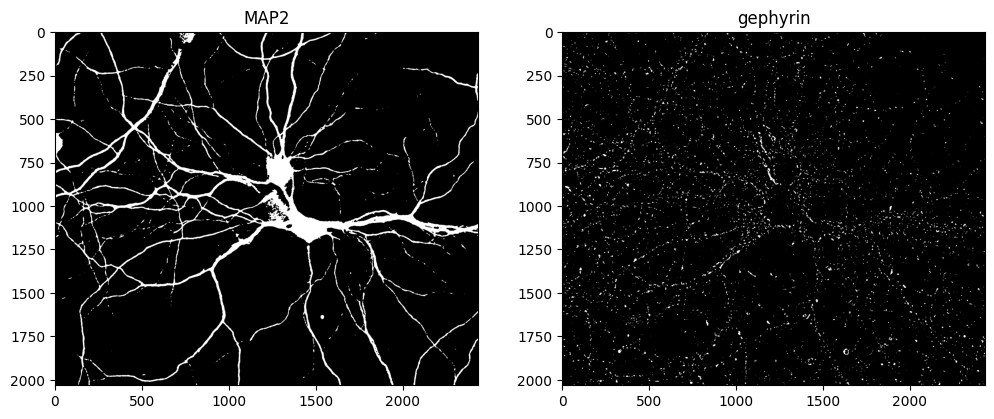

In [8]:
binary_map2 = threshold_map2(map2)
labeled_map2 = label(binary_map2)

binary_gphn = threshold_gphn(gphn)
labeled_gphn = label(binary_gphn)

fig, axes = plt.subplots(1, 2, figsize=(12, 12))

axes[0].imshow(binary_map2, cmap='gray')
axes[0].set_title("MAP2")

axes[1].imshow(binary_gphn, cmap='gray')
axes[1].set_title("gephyrin")

plt.show()


C:\Users\liebs\PycharmProjects\imageAnalysisNBC2025\.venv\lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


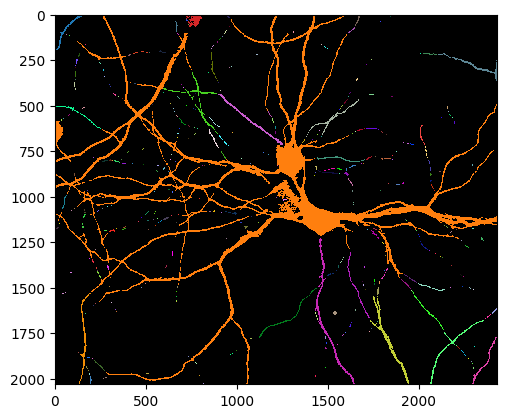

In [9]:
labeled_map2 = label(binary_map2)
imshow(labeled_map2, labels=True)

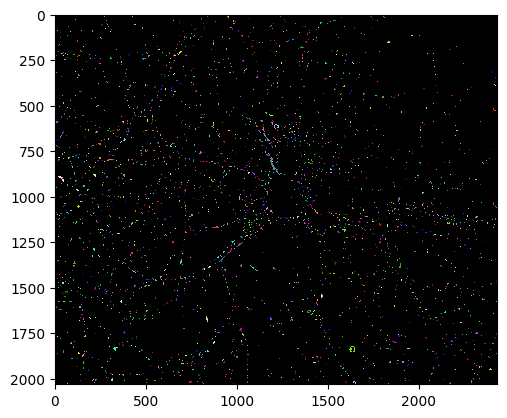

In [10]:
labeled_gphn = label(binary_gphn)
imshow(labeled_gphn, labels=True)

In [11]:
def get_voxel_size_from_aics_image(aics_image):
    return (aics_image.physical_pixel_sizes.Z,
            aics_image.physical_pixel_sizes.Y,
            aics_image.physical_pixel_sizes.X)

voxel = get_voxel_size_from_aics_image(img)

properties_gphn = measure.regionprops(labeled_gphn, intensity_image=gphn)
num_gphn = labeled_gphn.max()
properties_map2 = measure.regionprops(labeled_map2, intensity_image=map2)
map2_area_total = np.sum([p.area*voxel[1]*voxel[2] for p in properties_map2])

statistics = {
    'area_gphn':[p.area*voxel[1]*voxel[2] for p in properties_gphn],
    'intensity_gphn':[p.mean_intensity    for p in properties_gphn],
    'num_gphn':[num_gphn for p in properties_gphn],
    'area_map2_total':[map2_area_total*voxel[1]*voxel[2] for p in properties_gphn],
}

df = pd.DataFrame(statistics)
df

,area_gphn,intensity_gphn,num_gphn,area_map2_total
0,0.816354,19.265306,5578,28.615224
1,0.083301,13.700000,5578,28.615224
2,0.008330,11.000000,5578,28.615224
3,0.074971,8.333333,5578,28.615224
4,0.024990,7.000000,5578,28.615224
...,...,...,...,...
5573,0.124952,10.600000,5578,28.615224
5574,0.099962,8.583333,5578,28.615224
5575,0.066641,8.750000,5578,28.615224
5576,0.058311,8.857143,5578,28.615224


In [12]:
column_mean = df.mean()

# creating additional info
num_gphn_per_area = column_mean['num_gphn']/column_mean['area_map2_total']

image_name = '020525488MAP2546Gephyrin647Tom20Gr3 CNTRL_Region1 Gepyhrin.tif'
word = 'CNTRL'
if word in image_name:
    condition = 'CNTRL'
else:
    condition = 'Antimycin A'

result = {
    'area_gphn': [column_mean['area_gphn']],
    'intensity_gphn': [column_mean['intensity_gphn']],
    'num_gphn': [column_mean['num_gphn']],
    'area_map2_total': [column_mean['area_map2_total']],
    'num_gphn_per_area': [num_gphn_per_area],
    'image': [image_name],
    'condition': [condition]
}

dr = pd.DataFrame(result)
dr

,area_gphn,intensity_gphn,num_gphn,area_map2_total,num_gphn_per_area,image,condition
0,0.166579,11.724037,5578.0,28.615224,194.931201,020525488MAP2546Gephyrin647Tom20Gr3 CNTRL_Regi...,CNTRL


In [13]:
dr.to_excel("gphn_analysis.xlsx")